In [1]:
import quandl
import pandas as pd
import numpy as np
import talib
import csv
import warnings
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

In [2]:
def plot_in_sample_hidden_states(hmm_model,df,series):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(df)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True,figsize=[20,20]
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            series[mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

In [4]:
def merge_with_spy(df,spy):
    cut=df.loc['1993-01-29':]
    spy_out=spy[cut.index.strftime('%Y-%m-%d')]
    return cut,spy_out

In [15]:
def series_merge(a,b): #sometimes the series will be different length, this function makes each series only have the intersection of their date indices
    for i in a.index:
        if i not in b.index:
            a.drop(i,inplace=True)
    for i in b.index:
        if i not in b.index:
            b.drop(i,inplace=True)
    return(a,b)

In [17]:
import trading as td
from trading import generate_signals, eval_signals
from commodities import hard_tech,hard,hard_pct
from spy import spy,spy_pct

In [10]:
def hold_strat(row):
    return 1

In [18]:
trade=generate_signals(hard_pct,hold_strat)
hold_oil=eval_signals(hard_pct['pct_oil'],trade)

/Users/jamesbaker/miniconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


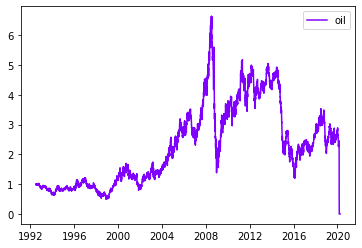

In [19]:
td.time_series_chart(oil=hold_oil)

In [55]:
train=hard_pct.iloc[:5000]
test=hard_pct.iloc[5000:6000]
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(train)

In [33]:
hmm_model

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [37]:
hmm_model.predict(test.iloc[0:1])

array([3])

In [41]:
def dumb_strat(row,hmm=hmm_model):
    ret=hmm.predict([row])
    return ret-1

In [48]:
tradeHMM=generate_signals(hard_pct['2015-01-01':],dumb_strat)

In [49]:
hmm_oil=eval_signals(hard_pct['pct_oil']['2015-01-01':],tradeHMM)

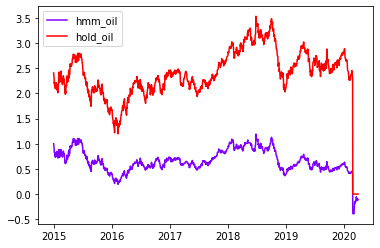

In [52]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [57]:
def simple_strat(row,hmm=hmm_model,mapping=[-1,0,1] ):
    ret=hmm.predict([row])[0]
    return mapping[ret]

In [58]:
tradeHMM2=generate_signals(hard_pct,simple_strat)

In [59]:
hmm_oil=eval_signals(hard_pct['pct_oil'],tradeHMM2)

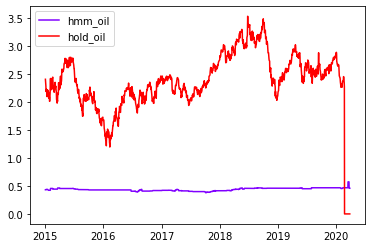

In [60]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [63]:
train=hard_tech.iloc[:5000]
test=hard_tech.iloc[5000:]
model_tech0=GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(train)

In [64]:
def tech_strat(row,hmm=model_tech0,mapping=[-1,0,1] ):
    ret=hmm.predict([row])[0]
    return mapping[ret]
tradeHMM_tech=generate_signals(test,tech_strat)

In [67]:
prices,sigs=series_merge(hard_pct['pct_oil'],tradeHMM_tech)
hmm_oil=eval_signals(prices,sigs)
#td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

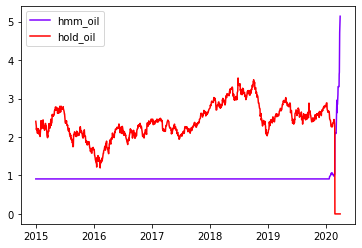

In [68]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [86]:
from functools import total_ordering

@total_ordering
class MarkovStrategy:
    def __init__(self,model,strat,params,returns,asset):
        self.strat=strat #strat function that returns -1,0,1
        self.params=params #the columns of the dataset taht feeds the input to the model
        self.returns=returns # the series actual returns that this portfolio yielded
        self.asset=asset #the name of the asset that this actually traded
        self.model=model #the actual markov model object
    
    def __lt__(self,other):
        return self.returns.iloc[len(self.returns)-1]<other.returns.iloc[len(other.returns)-1]
    
    def __eq__(self,other):
        self.returns.iloc[len(self.returns)-1]==other.returns.iloc[len(other.returns)-1]
        

In [84]:
spy_pct.name='pct_spy'
assets=hard_pct.join(spy_pct).dropna()

,pct_gold,pct_oil,pct_silver,pct_ruth,pct_irid,pct_pall,pct_rhod,pct_plat,pct_spy
Date,,,,,,,,,
1993-01-29,0.001728,-0.005397,0.006784,0.00,0.0,0.009009,0.000000,0.005510,0.000000
1993-02-01,-0.000590,0.002467,-0.010782,0.00,0.0,-0.008929,0.000000,-0.008219,0.007055
1993-02-02,-0.000712,-0.015748,0.002725,0.00,0.0,-0.009009,0.000000,-0.008287,0.002034
1993-02-04,-0.003910,0.014500,-0.001359,0.00,0.0,0.018182,0.000000,0.000000,0.004240
1993-02-05,-0.000548,-0.000986,0.001361,0.00,0.0,0.026786,0.000000,0.005571,-0.000667
...,...,...,...,...,...,...,...,...,...
2020-03-24,0.056237,-0.098586,0.101079,0.00,0.0,0.177331,0.000000,0.112540,0.090603
2020-03-25,0.026495,-0.013314,0.047533,0.00,0.0,0.065217,0.500000,0.046243,0.014970
2020-03-26,-0.007266,-0.200000,-0.007967,0.00,0.0,0.128280,0.212121,0.024862,0.058390


In [100]:
def test_model_mapping(df=hard_tech, model=GaussianHMM,n_components=3,assets=assets,train_size=5000,begin_date='2015-01-01'):
    #makes a Markov model using the df, and finds the optimal mapping from states to trade signals
    train=df.iloc[:train_size]
    hmm=model(n_components=3, covariance_type="full", n_iter=1000).fit(train)
    models=[]
    for mapping in [[1,0,-1],[1,-1,0],[0,1,-1],[0,-1,1],[-1,0,1],[-1,1,0]]:
        def strat(row,hmm=hmm,mapping=mapping):
            ret=hmm.predict([row])[0]
            return mapping[ret]
        trade=generate_signals(df.loc[begin_date:],strat)
        for asset in assets.columns:
            prices,sigs=series_merge(assets[asset][begin_date:],trade)
            perf=eval_signals(prices,sigs)
            print(perf.iloc[len(perf)-1],asset,mapping)
        

In [101]:
test_model_mapping()

1.3288994577502868 pct_gold [1, 0, -1]
6.95002996188381 pct_oil [1, 0, -1]
1.6115238755027583 pct_silver [1, 0, -1]
4.137931034482756 pct_ruth [1, 0, -1]
2.6859259259259245 pct_irid [1, 0, -1]
4.416826927391821 pct_pall [1, 0, -1]
2.56736728255757 pct_rhod [1, 0, -1]
1.3675320420951242 pct_plat [1, 0, -1]
2.042125504605915 pct_spy [1, 0, -1]
1.3513730914931184 pct_gold [1, -1, 0]
1.1175158303115087 pct_oil [1, -1, 0]
1.213941643032814 pct_silver [1, -1, 0]
4.310344827586205 pct_ruth [1, -1, 0]
2.7407407407407396 pct_irid [1, -1, 0]
3.703897420225351 pct_pall [1, -1, 0]
5.881392235609094 pct_rhod [1, -1, 0]
0.943435084545159 pct_plat [1, -1, 0]
1.7210920589891474 pct_spy [1, -1, 0]
0.9833697785723988 pct_gold [0, 1, -1]
6.219178085330998 pct_oil [0, 1, -1]
1.3275134638899568 pct_silver [0, 1, -1]
0.96 pct_ruth [0, 1, -1]
0.98 pct_irid [0, 1, -1]
1.1924808995177556 pct_pall [0, 1, -1]
0.4365237310671707 pct_rhod [0, 1, -1]
1.4495242592705004 pct_plat [0, 1, -1]
1.186528921529811 pct_spy 